# predict AAPL 5 minute rate of change, <br/> using 1 year IEX data

In [1]:
# imports
import common
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
# inputs
PREDICTION_SIZE = 5
aapl_file_path = r'C:\Users\asaf\Desktop\DS_workshop-project\iex_data\snp500\AAPL.csv'

## 1) get aaple data

In [3]:
df = pd.read_csv(aapl_file_path)
common.minimal_IEX_preprocessing(df)
df.drop(columns = ['symbol'], inplace=True)
df.head()

,high,low,open,close,average,volume,notional,numberOfTrades,datetime
0,191.645,190.60,191.645,190.65,191.189,4320.0,825935.940,44.0,2019-04-01 09:30:00
1,190.980,190.64,190.700,190.98,190.761,3246.0,619210.510,32.0,2019-04-01 09:31:00
2,191.090,190.78,191.060,190.93,190.951,2253.0,430211.740,30.0,2019-04-01 09:32:00
3,191.010,190.76,190.980,190.83,190.946,2241.0,427911.290,27.0,2019-04-01 09:33:00
4,190.760,190.60,190.760,190.70,190.666,1069.0,203822.465,12.0,2019-04-01 09:34:00


to keep things stupid simple, focus on specific columns

In [4]:
df.drop(columns=['high','low','open','average','notional', 'numberOfTrades'], inplace=True)
df.head()

,close,volume,datetime
0,190.65,4320.0,2019-04-01 09:30:00
1,190.98,3246.0,2019-04-01 09:31:00
2,190.93,2253.0,2019-04-01 09:32:00
3,190.83,2241.0,2019-04-01 09:33:00
4,190.70,1069.0,2019-04-01 09:34:00


## 2) preprocessing

first look

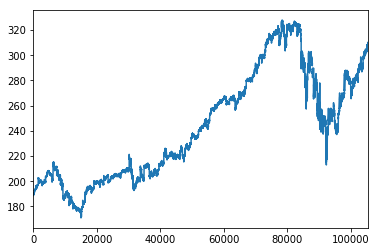

In [5]:
df['close'].plot()

### 2.1) dealing with Nans

look how many Nans we have

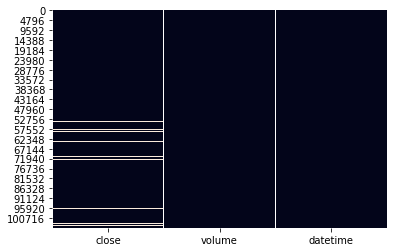

In [6]:
sns.heatmap(df.isnull(), cbar=False)

In [7]:
df.isnull().sum()

close       3219
volume         0
datetime       0
dtype: int64

fill Nan with most recent valid (non-Nan if you will) record

In [8]:
df.fillna(method='ffill', inplace=True)

are there still Nans?

In [9]:
df.isnull().sum()

close       0
volume      0
datetime    0
dtype: int64

good :-)

### 2.2) add features

add time columns

In [10]:
common.add_times(df, 'datetime')

In [11]:
df.head().transpose()

,0,1,2,3,4
close,190.65,190.98,190.93,190.83,190.7
volume,4320,3246,2253,2241,1069
datetime,2019-04-01 09:30:00,2019-04-01 09:31:00,2019-04-01 09:32:00,2019-04-01 09:33:00,2019-04-01 09:34:00
minute,30,31,32,33,34
hour,9,9,9,9,9
day,1,1,1,1,1
month,4,4,4,4,4
minute_of_day,570,571,572,573,574
day_of_week,0,0,0,0,0


calc different rocs

In [12]:
roc_vals = [1,3,5]
for val in roc_vals:
    df['roc'+str(val)] = common.rate_of_change(df, 'close', val)

In [13]:
df.head(6).transpose()

,0,1,2,3,4,5
close,190.65,190.98,190.93,190.83,190.7,190.85
volume,4320,3246,2253,2241,1069,4878
datetime,2019-04-01 09:30:00,2019-04-01 09:31:00,2019-04-01 09:32:00,2019-04-01 09:33:00,2019-04-01 09:34:00,2019-04-01 09:35:00
minute,30,31,32,33,34,35
hour,9,9,9,9,9,9
day,1,1,1,1,1,1
month,4,4,4,4,4,4
minute_of_day,570,571,572,573,574,575
day_of_week,0,0,0,0,0,0
roc1,NaN,0.00173092,-0.000261808,-0.000523752,-0.000681235,0.000786576


### 2.3) add target

In [14]:
df['target'] = common.rate_of_change(df, 'close', -PREDICTION_SIZE)

In [15]:
df.head(6).transpose()

,0,1,2,3,4,5
close,190.65,190.98,190.93,190.83,190.7,190.85
volume,4320,3246,2253,2241,1069,4878
datetime,2019-04-01 09:30:00,2019-04-01 09:31:00,2019-04-01 09:32:00,2019-04-01 09:33:00,2019-04-01 09:34:00,2019-04-01 09:35:00
minute,30,31,32,33,34,35
hour,9,9,9,9,9,9
day,1,1,1,1,1,1
month,4,4,4,4,4,4
minute_of_day,570,571,572,573,574,575
day_of_week,0,0,0,0,0,0
roc1,NaN,0.00173092,-0.000261808,-0.000523752,-0.000681235,0.000786576


### 2.4) final cleaning

drop first 5 minutes of every day (so we wont use roc5 which been calculated on data from yesterday)

In [16]:
df = df[df['minute_of_day'] >= 575]

drop last 5 minutes in whole dataset (missing targets)

In [17]:
df = df.iloc[:-PREDICTION_SIZE]

In [18]:
df.tail().transpose()

,105483,105484,105485,105486,105487
close,309.79,309.82,309.93,309.98,310.13
volume,2024,861,825,1356,3673
datetime,2020-05-08 15:50:00,2020-05-08 15:51:00,2020-05-08 15:52:00,2020-05-08 15:53:00,2020-05-08 15:54:00
minute,50,51,52,53,54
hour,15,15,15,15,15
day,8,8,8,8,8
month,5,5,5,5,5
minute_of_day,950,951,952,953,954
day_of_week,4,4,4,4,4
roc1,-0.000612943,9.68398e-05,0.000355045,0.000161327,0.000483902


drop datetime - as some models cant deal with this datatype

In [19]:
df.drop(columns=['datetime'], inplace=True)

## 3) modeling

how much data we have?

In [20]:
len(df)

104123

### 3.1) splitting data into training, validation, and test sets

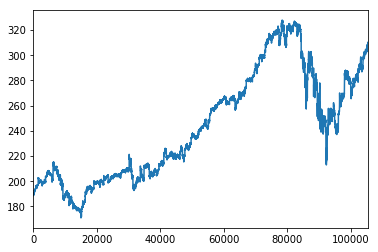

In [21]:
df['close'].plot()

splitting the data a little before the corona pandemic.

In [22]:
split_point = 70000
train_df = df.iloc[:split_point]
test_df = df.iloc[split_point:]

In [23]:
df.iloc[split_point]

close            291.440000
volume           163.000000
minute             3.000000
hour              11.000000
day               31.000000
month             12.000000
minute_of_day    663.000000
day_of_week        1.000000
roc1               0.000275
roc3               0.000859
roc5               0.000773
target            -0.001644
Name: 70920, dtype: float64

percentange wise:

In [24]:
print(f"train_df = {len(train_df) / len(df):.2f}")
print(f"test_df = {len(test_df) / len(df):.2f}")

train_df = 0.67
test_df = 0.33


### 3.2) evaluation metric
continuing the stupid simple spirit - i use MSE

### 3.3) baseline
baseline model will be a model which predict the current roc5 to be the next 5 minutes roc5 (target) <br/>
it is probably a terrible model - with little to no predictive value. <br/>
need to think of a way to measure that.

In [25]:
mean_squared_error(train_df['target'], train_df['roc5'])

4.7355247913895315e-06

In [26]:
mean_squared_error(test_df['target'], test_df['roc5'])

2.4231574324765553e-05

### 3.4) random forest

at first, i use simple 10 trees forest

In [27]:
train_features = train_df.drop(columns=['target'])

In [28]:
m_forest = RandomForestRegressor(n_estimators=10, n_jobs=-1, max_depth=5, random_state=1)
%time m_forest.fit(train_features, train_df['target'])

Wall time: 1.32 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [29]:
mean_squared_error(train_df['target'], m_forest.predict(train_features))

2.2959045938132926e-06

In [30]:
mean_squared_error(test_df['target'],
                   m_forest.predict(test_df.drop(columns=['target'])))

1.8180524324988743e-05

good results? <br/>
at least not worst than the baseline <br/>
note - in both models, training error > validation error - wierd

### 3.4) MLP

In [32]:
m_mlp = MLPRegressor(hidden_layer_sizes=tuple([20 for _ in range(20)]), 
                     random_state=1,
                     activation='logistic')
%time m_mlp.fit(train_features, train_df['target'])

Wall time: 28.4 s


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20),
       learning_rate='constant', learning_rate_init=0.001, max_iter=200,
       momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
       power_t=0.5, random_state=1, shuffle=True, solver='adam',
       tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [33]:
mean_squared_error(train_df['target'], m_mlp.predict(train_features))

3.383756360838726e-06

In [34]:
mean_squared_error(test_df['target'],
                   m_mlp.predict(test_df.drop(columns=['target'])))

1.743965240603901e-05

random forest > MLP in sample, <br/>
random forest < MLP out of sample.

thinking face

calculate PnL

In [35]:
print(f" PnL forest = {common.rate_of_change_PL(m_forest.predict(train_features), train_df['target']).mean()}")
print(f" PnL MLP    = {common.rate_of_change_PL(m_mlp.predict(train_features), train_df['target']).mean()}")

 PnL forest = 7.557481707322778e-05
 PnL MLP    = -2.380681515183821e-05


In [36]:
print(f" PnL forest = {common.rate_of_change_PL(m_forest.predict(test_df.drop(columns=['target'])), test_df['target']).mean()}")
print(f" PnL MLP    = {common.rate_of_change_PL(m_mlp.predict(test_df.drop(columns=['target'])), test_df['target']).mean()}")

 PnL forest = -5.934871068251125e-05
 PnL MLP    = -1.933951081108136e-06


lossing money :(